# Delta‑ & σ‑Hedging under Stochastic Volatility
_A mini‑project workbook_


This notebook explores:

* How delta‑hedging a short European call performs when volatility is **not constant**  
* How adding a **σ‑(vega‑) hedge** collapses the P&L dispersion  
* Three volatility engines you can switch between:
  1. **Custom discrete σ** per step (starter code)  
  2. **Heston** stochastic volatility  
  3. **GARCH(1, 1)** with volatility clustering


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

sns.set_style('darkgrid')


## 1  Custom per‑step σ
A quick toy model: every time‑step the volatility is randomly chosen from a fixed set.

In [2]:

def stock_path_custom_sigma(S0, T, r, mu, n_paths=10_000, n_steps=252):
    """Discrete‑time GBM with i.i.d. σ at each step"""
    noise  = np.random.normal(size=(n_paths, n_steps))
    sigma  = np.random.choice([0.2, 0.3, 0.45], p=[0.5, 0.3, 0.2],
                              size=(n_paths, n_steps))
    dt = T / n_steps
    increments = (mu + r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0 * np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis=1)
    return paths, sigma


## 2  Heston stochastic volatility

In [3]:

def heston_paths(S0, v0, mu, r,
                 kappa, theta, xi, rho,
                 T=1.0, n_steps=252, n_paths=10_000, floor=1e-8):
    dt   = T / n_steps
    S    = np.zeros((n_paths, n_steps+1))
    v    = np.zeros_like(S)
    S[:,0] = S0
    v[:,0] = v0
    for t in range(1, n_steps+1):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)
        w1 = z1
        w2 = rho*z1 + np.sqrt(1 - rho**2)*z2
        v_prev = v[:,t-1]
        v_next = np.maximum(v_prev + kappa*(theta - v_prev)*dt
                            + xi*np.sqrt(v_prev*dt)*w2, floor)
        S[:,t] = S[:,t-1]*np.exp((mu - 0.5*v_prev)*dt
                                 + np.sqrt(v_prev*dt)*w1)
        v[:,t] = v_next
    return S, np.sqrt(v)      # return σ_t


## 3  GARCH(1, 1) volatility clustering

In [4]:

def garch_paths(S0, mu, r,
                omega, alpha, beta,
                T=1.0, n_steps=252, n_paths=10_000):
    dt   = T / n_steps
    S    = np.zeros((n_paths, n_steps+1))
    sig2 = np.zeros_like(S)
    S[:,0]    = S0
    sig2[:,0] = omega / (1 - alpha - beta)      # long‑run variance
    for t in range(1, n_steps+1):
        z   = np.random.normal(size=n_paths)
        eps = np.sqrt(sig2[:,t-1])*np.sqrt(dt)*z
        sig2[:,t] = (omega + alpha*eps**2/dt + beta*sig2[:,t-1])
        S[:,t] = S[:,t-1]*np.exp((mu - 0.5*sig2[:,t-1])*dt
                                 + np.sqrt(sig2[:,t-1]*dt)*z)
    return S, np.sqrt(sig2)


## 4  Black–Scholes price & greeks

In [5]:

def bs_price(S, K, T, r, sigma, call=True):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if call:
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def bs_greeks(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    delta = norm.cdf(d1)
    vega  = S * norm.pdf(d1) * np.sqrt(T)
    gamma = norm.pdf(d1) / (S*sigma*np.sqrt(T))
    return delta, vega, gamma


## 5  Hedging engines

In [6]:

def delta_hedge_path(S_path, sig_path, K, r, dt):
    """Discounted P&L of a *short* call hedged only with shares."""
    n_steps = len(S_path) - 1
    cash   = 0.0
    # open
    T_rem  = n_steps*dt
    P0     = bs_price(S_path[0], K, T_rem, r, sig_path[0])
    delta, *_ = bs_greeks(S_path[0], K, T_rem, r, sig_path[0])
    shares = delta
    cash -= shares*S_path[0] - P0
    for t in range(1, n_steps):
        cash *= np.exp(r*dt)
        T_rem = (n_steps - t)*dt
        delta_new, *_ = bs_greeks(S_path[t], K, T_rem, r, sig_path[t])
        d_shares = delta_new - shares
        cash -= d_shares*S_path[t]
        shares = delta_new
    cash *= np.exp(r*dt)
    payoff = max(S_path[-1] - K, 0.0)
    pnl = cash + shares*S_path[-1] - payoff
    return pnl


## 6  Monte‑Carlo wrapper

In [7]:

def experiment(model='heston', n_paths=5_000,
               delta_hedge=True, seed=1234):
    np.random.seed(seed)
    # market setup
    S0, K, r, mu = 100, 100, 0.02, 0.0
    T, n_steps   = 1.0, 252
    dt           = T / n_steps

    # choose a volatility engine
    if model == 'custom':
        S, sig = stock_path_custom_sigma(S0, T, r, mu,
                                         n_paths=n_paths, n_steps=n_steps)
    elif model == 'heston':
        S, sig = heston_paths(S0, v0=0.04, mu=mu, r=r,
                              kappa=2.0, theta=0.04, xi=0.35, rho=-0.5,
                              T=T, n_steps=n_steps, n_paths=n_paths)
    elif model == 'garch':
        S, sig = garch_paths(S0, mu, r,
                             omega=5e-6, alpha=0.06, beta=0.93,
                             T=T, n_steps=n_steps, n_paths=n_paths)
    else:
        raise ValueError("model must be 'custom', 'heston', or 'garch'")

    pnl = np.empty(n_paths)
    for i in range(n_paths):
        pnl[i] = delta_hedge_path(S[i], sig[i], K, r, dt)
    return pnl


## 7  Experiment – Heston  (1 000 paths)

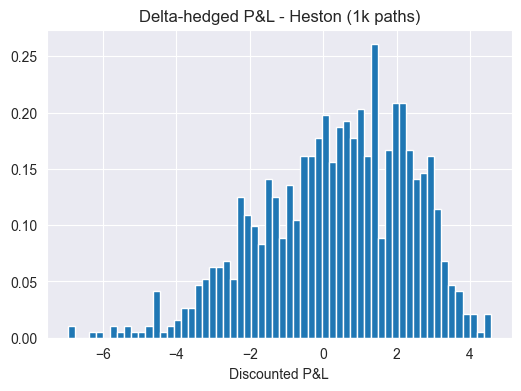

Mean = 0.3296,  Std = 2.0259


In [11]:

pnl_heston = experiment('heston', n_paths=1_000)
plt.figure(figsize=(6,4))
plt.hist(pnl_heston, bins=60, density=True)
plt.title("Delta-hedged P&L - Heston (1k paths)")
plt.xlabel("Discounted P&L")
plt.show()
print(f"Mean = {pnl_heston.mean():.4f},  Std = {pnl_heston.std():.4f}")


## 8  Experiment – GARCH  (1 000 paths)

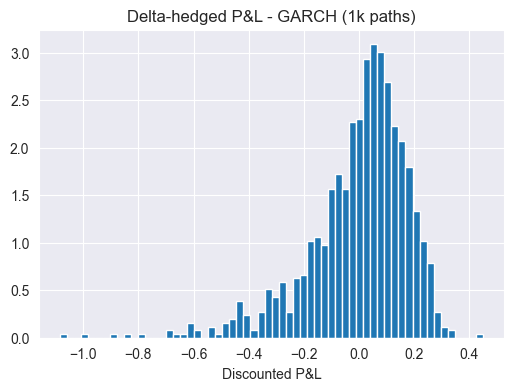

Mean = -0.0034,  Std = 0.1850


In [12]:

pnl_garch = experiment('garch', n_paths=1_000)
plt.figure(figsize=(6,4))
plt.hist(pnl_garch, bins=60, density=True)
plt.title("Delta-hedged P&L - GARCH (1k paths)")
plt.xlabel("Discounted P&L")
plt.show()
print(f"Mean = {pnl_garch.mean():.4f},  Std = {pnl_garch.std():.4f}")



---  
### Things to try
* Increase `n_paths` to 20 000–50 000 for smoother histograms.  
* Add a **vega hedge**: choose a second call and solve `vega₁ + q·vega₂ = 0` each rebalance.  
* Insert bid‑ask spreads per share & per option and study the breakeven.
